# <font color="red">Projet Régression Linéaire</font>

In [252]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [263]:
df = pd.read_csv("data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## <font color="blue">Traitement des données</font>

In [264]:
df["date"] = pd.to_datetime(df["date"])
df["renovation"] = df["date"].dt.year - df['yr_built']
df['renovation'][df['yr_renovated'] != 0] = df["date"].dt.year - df["yr_renovated"]
df['renovation'][df['renovation'] < 0] = 0
df["date"] = (df["date"] - df["date"].min()).dt.days
df["ln_price"] = np.log(df["price"])
df = df[df["bedrooms"]<20]

C:\Users\APPREN~1\AppData\Local\Temp/ipykernel_3348/2256284547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['renovation'][df['yr_renovated'] != 0] = df["date"].dt.year - df["yr_renovated"]
C:\Users\APPREN~1\AppData\Local\Temp/ipykernel_3348/2256284547.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['renovation'][df['renovation'] < 0] = 0


## <font color="blue">Création des pipeline</font>

In [265]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [266]:
poly_features = ["sqft_living", "sqft_living15", "bathrooms","bedrooms","sqft_above"]
non_poly_features = ["date", "sqft_lot", "sqft_lot15","floors","lat","long","renovation","sqft_basement", "grade"]
hot_encode_features = ["zipcode", "view", "condition", "waterfront"]

poly_pipeline = make_pipeline(PolynomialFeatures(), RobustScaler())
hot_encode_pipeline = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))
non_poly_pipeline = make_pipeline(RobustScaler())

processor = make_column_transformer((poly_pipeline, poly_features), (non_poly_pipeline,non_poly_features),
                                       (hot_encode_pipeline,hot_encode_features))

In [288]:
lr = make_pipeline(processor, LinearRegression())
ridge = make_pipeline(processor, Ridge(alpha=0.2))
lasso = make_pipeline(processor, Lasso()) # lasso inutilisable puisque OneHotEncoder sans standardisation
elasticnet = make_pipeline(processor, ElasticNet(l1_ratio=0))

## <font color="blue">Modèles</font>

In [268]:
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import explained_variance_score,max_error,mean_absolute_error,mean_squared_error,r2_score, mean_squared_log_error

In [269]:
X = df.drop(["price", "ln_price", "id","yr_renovated","yr_built"], axis=1)
y = df["ln_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
X_train_fortran = np.asfortranarray(X_train)

In [270]:
def eval_metrics(y_test, y_pred):
    print(f'explained_variance_score = {explained_variance_score(y_test, y_pred)}')
    print(f'max error = {max_error(y_test, y_pred)}')
    print(f'RMSE = {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'MSLE = {mean_squared_log_error(y_test, y_pred)}')
    print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
    print(f'R²= {r2_score(y_test, y_pred)}')

### <font color="green">Linear Regression</font>

explained_variance_score = 0.884259015743248
max error = 3588002.3962926
RMSE = 137463.13576310594
MSLE = 0.03135671261125029
MAE = 72277.92197124587
R²= 0.883693455148984
0.8867906221574955


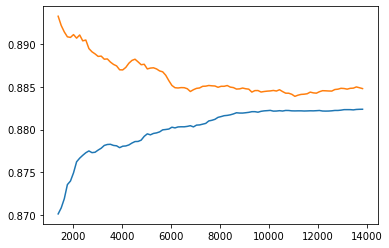

In [271]:
reg = lr.fit(X_train, y_train)
train_size, train_score, val_score = learning_curve(lr, X_train, y_train,train_sizes=np.linspace(0.1,1,100), cv=5,
                                                    shuffle=True, scoring='r2')
plt.plot(train_size, val_score.mean(axis=1), label="Validation")
plt.plot(train_size, train_score.mean(axis=1), label="train")

pred = lr.predict(X_test)
eval_metrics(np.exp(y_test), np.exp(pred))
print(cross_val_score(lr,X_test,y_test,cv=10).mean())

### <font color="green">Ridge</font>

explained_variance_score = 0.8841114990263511
max error = 3591961.6213055607
RMSE = 137553.03026534984
MSLE = 0.03137107102847475
MAE = 72306.66713151774
R²= 0.8835412872598204
0.88683020874834


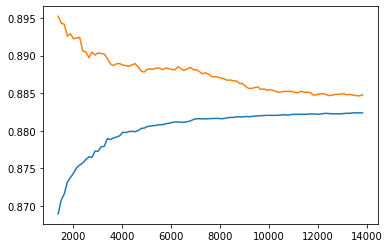

In [289]:
reg = ridge.fit(X_train, y_train)
train_size, train_score, val_score = learning_curve(ridge, X_train, y_train,train_sizes=np.linspace(0.1,1,100), cv=5,
                                                    shuffle=True, scoring='r2')
plt.plot(train_size, val_score.mean(axis=1), label="Validation")
plt.plot(train_size, train_score.mean(axis=1), label="train")

pred = ridge.predict(X_test)
eval_metrics(np.exp(y_test), np.exp(pred))
print(cross_val_score(ridge,X_test,y_test,cv=10).mean())

### <font color="green">Lasso</font>

In [ ]:
# reg = lasso.fit(X_train, y_train)
# train_size, train_score, val_score = learning_curve(lasso, X_train, y_train,train_sizes=np.linspace(0.1,1,100), cv=2,
#                                                     shuffle=True, scoring='r2')
# plt.plot(train_size, val_score.mean(axis=1), label="Validation")
# plt.plot(train_size, train_score.mean(axis=1), label="train")

# pred = lasso.predict(X_test)
# print(lasso.score(X_test,y_test))
# eval_metrics(np.exp(y_test), np.exp(pred))
# print(cross_val_score(lasso,X_test,y_test,cv=10).mean())

### <font color="green">ElasticNet</font>

In [ ]:
# reg= elasticnet.fit(X_train, y_train)
# train_size, train_score, val_score = learning_curve(elasticnet, X_train, y_train,train_sizes=np.linspace(0.1,1,100), cv=2,
#                                                     shuffle=True, scoring='r2')
# plt.plot(train_size, val_score.mean(axis=1), label="Validation")
# plt.plot(train_size, train_score.mean(axis=1), label="train")

# pred = elasticnet.predict(X_test)
# elasticnet.score(X_test,y_test)
# eval_metrics(np.exp(y_test), np.exp(pred))
# print(cross_val_score(elasticnet,X_test,y_test,cv=10).mean())

In [ ]:
from sklearn.model_selection import GridSearchCV

## Optimisation des paramètres

In [287]:
param_ridge = {"ridge__alpha": np.arange(0.1,1,0.1)}
# param_lasso = {"lasso__alpha": np.arange(0.00001, 0.0001, 0.00001)}
# grid_lasso = GridSearchCV(lasso, param_lasso, cv=5) #détermination du meilleur hyperparamètre alpha de Lasso
grid_ridge = GridSearchCV(ridge, param_ridge, cv=5) #détermination du meilleur hyperparamètre alpha de Ridge
# grid_lasso.fit(X_train, y_train)
grid_ridge.fit(X_train, y_train)
# print(f"Lasso : {grid_lasso.best_params_}")
print(f'Ridge : {grid_ridge.best_params_}')

Ridge : {'ridge__alpha': 0.2}
